<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

請參考範例程式碼Day087_CB_ReduceLR.ipynb

作業１：請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

作業２：請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

作業請提交Day087HW.ipynb

In [ ]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train, test = keras.datasets.cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [ ]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [ ]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [ ]:

"""
# 載入 Callbacks, 並設定監控目標為 validation loss

參數說明：
monitor: 監控目標
min_lr: 最低下降至多少學習率
factor: 每次學習率要下降多少
patience: 經過多少 Epoch 後模型沒有改善時會使用該功能

"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.3,
                              min_lr=1e-12,
                              monitor='val_loss',
                              patience=7,
                              verbose=1)

In [ ]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 3072))
  warnings.warn(msg)


49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.3188 - loss: 2.0629 - val_accuracy: 0.2151 - val_loss: 2.3210 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.4526 - loss: 1.5499 - val_accuracy: 0.3341 - val_loss: 1.8466 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4938 - loss: 1.4302 - val_accuracy: 0.3491 - val_loss: 1.8126 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.5254 - loss: 1.3482 - val_accuracy: 0.3511 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.5448 - loss: 1.2944 - val_accuracy: 0.3292 - val_loss: 1.9066 - learning_rate: 0.0010
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.5591 - loss: 1.2546 - val_accuracy: 0.3507 - val_loss: 1.9341 - learning_rate: 0.0010
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.5759 - loss: 1.2017 - val_a

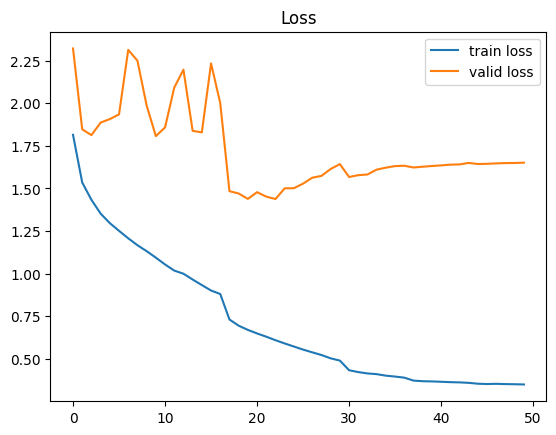

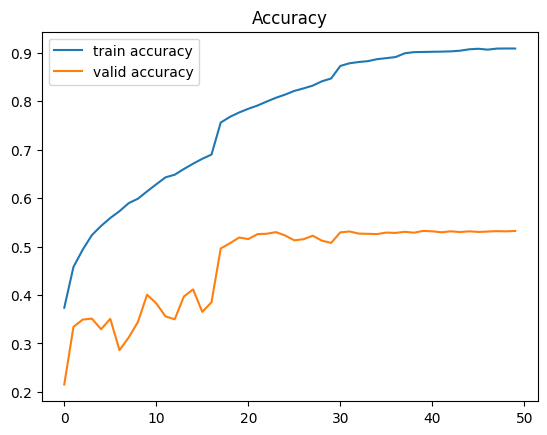

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()